# Using Deep Q-Learning to land on the moon

We will use openai-gym, which packages a bunch of environments with a unified API. First, run the next cell to install relevant packages.

In [1]:
!pip3 install gym gym[classic_control] gym[box2d]
!pip3 install box2d-py

Our environment of choice will be [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/).

Since it is complicated to display the real game frames from the environment, we will use our own visualization.

**Todo :** 
- Read the documentation of the LunarLander-v2 environment to figure out what is contained in the variable ```observation```. 
- Complete the next cell to collect 20 trajectories (of maximum length 100) and plot them.

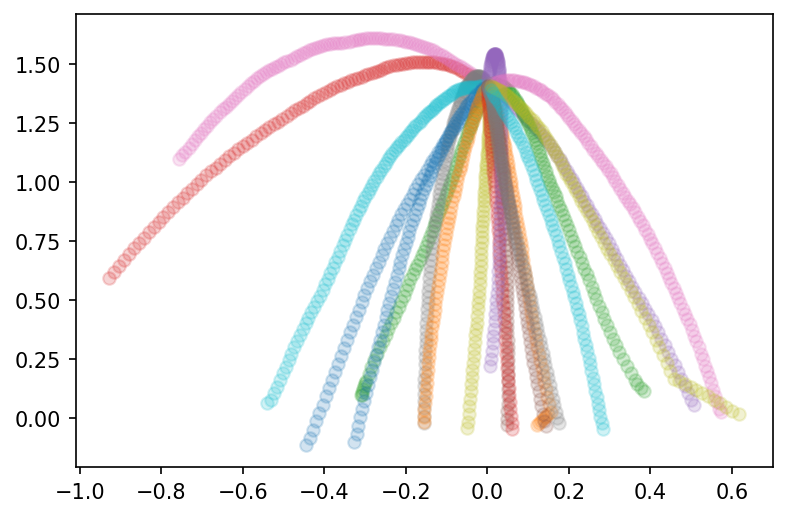

In [6]:
import gym
import torch
env = gym.make('LunarLander-v2')
positions = []
for i_episode in range(20):
    this_episode = []
    observation = env.reset()
    for t in range(100):
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        this_episode.append(torch.from_numpy(observation)[None,:])
        if done:
            break
    positions.append(torch.cat(this_episode))
env.close()

from matplotlib import pyplot as plt
plt.figure(dpi=150)
for x in positions:
    plt.scatter(x[:, 0], x[:, 1], alpha=0.2)
plt.show()

# Deep Q-Learning

We use a slightly more complex Q function, to model uncertainty in the environment: 
$$Q(s_t, a_t) = r(s_t, a_t) + \gamma \sum_{s_{t+1}}\max_aQ(s_{t+1}, a)p(s_{t+1}|s_t, a_t)$$

In Q-learning, we attempt to learn the Q-function by using _temporal differences_ :

Given a transition $(s_t, a_t, s_{t+1})$, we minimize $\left(Q(s_t, a_t) - (r(s_t, a_t) + \gamma * max_aQ(s_{t+1}, a))\right)^2$.

Note that the probability of observing such a transition is given by $p(s_{t+1}|s_t, a_t)$ so the weighting comes from the sampling of transitions. 

We need a **replay buffer** that will store transitions so we can train on them. This data-structure must have 2 methods :
- Push(batch of transitions) which saves this batch of transitions in the buffer
- Sample(batch_size) which returns batch_size transitions chosen uniformly at random in the buffer.

In the following cell is the implementation of a replay buffer of fixed memory size. The implementation uses a [Circular Buffer](https://en.wikipedia.org/wiki/Circular_buffer)

**Todo:** Fill in the sample method.

In [7]:
class ReplayBuffer(object):
    def __init__(self, size):
        self.buffers = {
            'state': torch.zeros(size, 8),  # 8 is the size of the observation
            'next_state': torch.zeros(size, 8),  # 8 is the size of the observation
            'reward': torch.zeros(size, 1),
            'action': torch.zeros(size, 1).long(),
            'done': torch.zeros(size, 1).byte()
        } 
        self.size = size
        self.total = 0
        self.insert = 0
        self.device = self.buffers['state'].device

    def to(self ,device):
        for x in self.buffers.keys():
            self.buffers[x] = self.buffers[x].to(device)
        self.device = device
        return self

    def push(self, episode):
        n_elem = episode['state'].shape[0]
        # first convert episode to a tensor
        if self.insert + n_elem < self.size:
            for key in episode.keys():
                self.buffers[key][self.insert:self.insert + n_elem] = episode[key][:n_elem].to(self.device)
                # x[self.insert:self.insert + n_elem] means take elements starting from self.insert and up to self.insert + n_elem
            self.insert += n_elem
        else:
            split = self.size - self.insert
            for key in episode.keys():
                self.buffers[key][self.insert:self.insert + split] = episode[key][:split].to(self.device)
                self.buffers[key][:(n_elem-split)] = episode[key][split:n_elem].to(self.device)
            self.insert = n_elem - split
        self.total = min(self.total + n_elem, self.size)

    def sample(self, batch_size):
        """
            Select batch_size random elements in the buffer.
            Return a dictionary {key : tensor} for each key in self.buffer
            WARNING: there are only self.total elements in the buffer !!!
        """
        samples = torch.randperm(self.total)[:batch_size]
        return {x:y[samples] for x,y in self.buffers.items()}

    def get_episode_buffer(self, max_episode_length):
        return {
            'state': torch.zeros(max_episode_length, 8),
            'next_state': torch.zeros(max_episode_length, 8),
            'reward': torch.zeros(max_episode_length, 1),
            'action': torch.zeros(max_episode_length, 1).long(),
            'done': torch.zeros(max_episode_length, 1).byte()
        } 

We can test our implementation

In [8]:
a = ReplayBuffer(3).to('cuda:0')


for i in range(5):
    a.push({
        'state': torch.ones(2, 8) * i,
        'reward': torch.ones(2, 1) * i,
        'next_state': torch.ones(2, 8) * i,
        'reward': torch.ones(2, 1) * i,
        'action': torch.ones(2, 1).long() * i,
        'done': torch.zeros(2, 1).byte()
    })
sample = a.sample(2)
# Check that all keys are there and shapes are correct
for k in a.buffers.keys():
    assert k in sample, f"Error {k} missing in sample"
    assert sample[k].shape[0] == 2 and sample[k].shape[1], f"Error, wrong shape, expected {2, a.buffers[k].shape[1]} and got {sample[k].shape}"
assert sample['state'].min().item() >= 3 and sample['state'].max().item() <= 4


RuntimeError: cuda runtime error (100) : no CUDA-capable device is detected at /pytorch/aten/src/THC/THCGeneral.cpp:50

This code learns a QFunction for the LunarLander problem.

**Todo:**
- Complete the line pushing observations to the replay buffer
- Run the code. It should take a while

In [ ]:
import gym
import torch
from torch import nn
from torch import optim
import numpy as np

env = gym.make('LunarLander-v2')
rb = ReplayBuffer(100_000).to('cuda:0')
batch_size = 64
gamma = 0.99

n_episodes = 1000
avg_reward = []
losses = []
epsilon = 1.
decay = 0.995
update_every = 5
learning_rate = 5e-4

class QFunction(nn.Module):
    def __init__(self):
        super(QFunction, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(8, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.mlp(x)

model = QFunction().to('cuda:0')
target = QFunction().to('cuda:0')

optimizer = optim.Adam(model.parameters(), lr=learning_rate)


all_rewards = []
for e in range(n_episodes):
    observation = env.reset()
    t=0
    total_reward = 0    
    for frame in range(1000):  # max frames
    # while True:
        if torch.rand(1).item() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = torch.argmax(model.forward(torch.from_numpy(observation).to('cuda:0'))).item()
        new_observation, reward, done, info = env.step(action)
        total_reward += reward
        rb.push({
            'state': torch.from_numpy(observation)[None, ...],
            'next_state': torch.from_numpy(new_observation)[None, ...],
            'reward': torch.tensor(reward)[None, None],
            'done': torch.tensor(done)[None, None],
            'action': torch.tensor(action)[None, None]
        }, 1)
        if done:
            break
        t += 1
        observation = new_observation
        if rb.total > batch_size and t % update_every == 0:
            sample = rb.sample(batch_size)
            these_q = torch.gather(model.forward(sample['state']), 1, sample['action']).squeeze()
            next_q = torch.max(target.forward(sample['next_state']).detach(), 1).values
            td_errors = (these_q - gamma * (
                sample['reward'].squeeze() + (1 - sample['done'].squeeze()) * next_q
            )) ** 2
            loss = torch.mean(td_errors)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            # target.load_state_dict(model.state_dict())
            tau = 1e-2
            for target_param, local_param in zip(target.parameters(), model.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    epsilon = max(epsilon * decay, 0.01)
    avg_reward.append(total_reward)
    all_rewards.append(total_reward)

    if (e+1) % 25 == 0:
        print(np.mean(avg_reward), np.mean(losses), epsilon)
        avg_reward = []
        losses = []

env.close()

plt.figure(dpi=150)
plt.plot(all_rewards)
plt.show()

Now that the model is learned, let's use it to produce trajectories and plot them.

**Todo:**
- Replace the code sampling a random action by code selecting the action leading to the maximum $Q(s,a)$.

Is the model better ?

In [ ]:
import gym
import torch
env = gym.make('LunarLander-v2')
positions = []
for i_episode in range(20):
    this_episode = []
    observation = env.reset()
    for t in range(500):
        action = torch.argmax(model.forward(torch.from_numpy(observation).to('cuda:0'))).item()
        observation, reward, done, info = env.step(action)
        this_episode.append(torch.from_numpy(observation)[None,:])
        if done:
            break
    positions.append(torch.cat(this_episode))
env.close()

from matplotlib import pyplot as plt
plt.figure(dpi=150)
for x in positions:
    plt.scatter(x[:, 0], x[:, 1], alpha=0.2)
plt.show()

# Not seen in class : Prioritized 2DQN

In [ ]:
class PrioritizedReplayBuffer(object):
    def __init__(self, size):
        self.buffers = {
            'state': torch.zeros(size, 8),
            'next_state': torch.zeros(size, 8),
            'reward': torch.zeros(size, 1),
            'action': torch.zeros(size, 1).long(),
            'done': torch.zeros(size, 1).byte(),
            'priority': torch.zeros(size, 1)
        } 
        self.size = size
        self.total = 0
        self.insert = 0
        self.device = self.buffers['state'].device

    def to(self ,device):
        for x in self.buffers.keys():
            self.buffers[x] = self.buffers[x].to(device)
        self.device = device
        return self

    def push(self, episode, n_elem):
        # first convert episode to a tensor
        if self.insert + n_elem < self.size:
            for key in episode.keys():
                self.buffers[key][self.insert:self.insert + n_elem] = episode[key][:n_elem].to(self.device)
            self.buffers['priority'][self.insert:self.insert + n_elem] = 1_000
            self.insert += n_elem
        else:
            split = self.size - self.insert
            for key in episode.keys():
                self.buffers[key][self.insert:self.insert + split] = episode[key][:split].to(self.device)
                self.buffers[key][:(n_elem-split)] = episode[key][split:n_elem].to(self.device)
            self.buffers['priority'][self.insert:self.insert + split] = 1_000
            self.buffers['priority'][:(n_elem-split)] = 1_000
            self.insert = n_elem - split
        self.total = min(self.total + n_elem, self.size)

    def sample(self, batch_size):
        priorities = self.buffers['priority'][:self.total].squeeze() + 1
        priorities /= priorities.sum()
        
        distrib = torch.distributions.categorical.Categorical(priorities)
        samples = distrib.sample((batch_size,)).to(self.device)
        
        weights = 1. / ((priorities) * self.total) 
        weights = (weights / torch.max(weights))[samples]

        return {x: y[samples] for x,y in self.buffers.items()}, weights, samples

    def get_episode_buffer(self, max_episode_length):
        return {
            'state': torch.zeros(max_episode_length, 8),
            'next_state': torch.zeros(max_episode_length, 8),
            'reward': torch.zeros(max_episode_length, 1),
            'action': torch.zeros(max_episode_length, 1).long(),
            'done': torch.zeros(max_episode_length, 1).byte()
        }

    def update(self, td_errors, id_samples):
        self.buffers['priority'][id_samples] = td_errors

In [ ]:
import gym
import torch
from torch import nn
from torch import optim
import numpy as np

env = gym.make('LunarLander-v2')
rb = PrioritizedReplayBuffer(100_000).to('cuda:0')
batch_size = 64
gamma = 0.99

n_episodes = 2000
avg_reward = []
losses = []
epsilon = 1.
decay = 0.995
update_every = 5
learning_rate = 5e-4

class QFunction(nn.Module):
    def __init__(self):
        super(QFunction, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(8, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.mlp(x)

model = QFunction().to('cuda:0')
target = QFunction().to('cuda:0')

best_so_far = 0

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

all_rewards_prioritized = []
all_positions = []
for e in range(n_episodes):
    observation = env.reset()
    t=0
    total_reward = 0    
    for frame in range(500):  # max frames
    # while True:
        if torch.rand(1).item() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = torch.argmax(model.forward(torch.from_numpy(observation).to('cuda:0'))).item()
        new_observation, reward, done, info = env.step(action)
        all_positions.append(new_observation[:2])
        total_reward += reward
        rb.push({
            'state': torch.from_numpy(observation)[None, ...],
            'next_state': torch.from_numpy(new_observation)[None, ...],
            'reward': torch.tensor(reward)[None, None],
            'done': torch.tensor(done)[None, None],
            'action': torch.tensor(action)[None, None]
        }, 1)
        if done:
            break
        t += 1
        observation = new_observation
        if rb.total > batch_size and t % update_every == 0:
            sample, weights, id_samples = rb.sample(batch_size)
            these_q = torch.gather(model.forward(sample['state']), 1, sample['action']).squeeze()
            next_q = torch.max(target.forward(sample['next_state']).detach(), 1).values
            td_errors = (these_q - gamma * (
                sample['reward'].squeeze() + (1 - sample['done'].squeeze()) * next_q
            )) ** 2
            loss = torch.mean(td_errors * weights)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

            # update priorities with new td_errors
            rb.update(td_errors[:, None].sqrt().detach(), id_samples)

            # target.load_state_dict(model.state_dict())
            tau = 1e-2
            for target_param, local_param in zip(target.parameters(), model.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    epsilon = max(epsilon * decay, 0.01)
    avg_reward.append(total_reward)
    all_rewards_prioritized.append(total_reward)
    if (e+1) % 25 == 0:
        print(np.mean(avg_reward), np.mean(losses), epsilon)
        cur = np.mean(avg_reward)
        if cur > best_so_far:
            torch.save(model.cpu(), 'model.torch')
            best_so_far = cur
        avg_reward = []
        losses = []

env.close()

plt.figure(dpi=150)
plt.plot(all_rewards_prioritized)
plt.show()

In [ ]:
plt.figure(dpi=150)
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(all_rewards_prioritized, n=100), label="2DQN-prioritized")
plt.plot(moving_average(all_rewards, n=100), label="2DQN")
plt.legend()
plt.show()

In order to do a nice density plot out of many 2d points, we can use kdeplot in seaborn.

In [ ]:
import seaborn as sns
 
# Basic 2D density plot
# all_positions = np.concatenate(all_positions).reshape(-1, 2)
sns.set_style("white")
sns.kdeplot(all_positions[:, 0][::10], all_positions[:, 1][::10], n_levels=20, cmap="Purples_d")
